In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os

In [11]:
#read data and fix
field_data = pd.read_csv('Image_data/gt.csv', sep=';')
#I filter away temporary plots (comment the following line to avoid that)
field_data = field_data[field_data['radius'] == 10]

lidr_data = pd.read_csv('Image_data/lidr-metrics.csv', sep=';')


In [12]:
#read shapefiles that determine areas, and convert to SWEREF99TM system
shapefile_gotaland = gpd.read_file(r"Image_data/götaland/götaland.shp").to_crs(epsg=3006)
shapefile_svealand = gpd.read_file(r"Image_data/svealand/svealand.shp").to_crs(epsg=3006)
shapefile_sodra_norrland = gpd.read_file(r"Image_data/södra_norrland/södra_norrland.shp").to_crs(epsg=3006)
shapefile_norra_norrland = gpd.read_file(r"Image_data/norra_norrland/norra_norrland.shp").to_crs(epsg=3006)

<Axes: xlabel='zq95', ylabel='Hgv'>

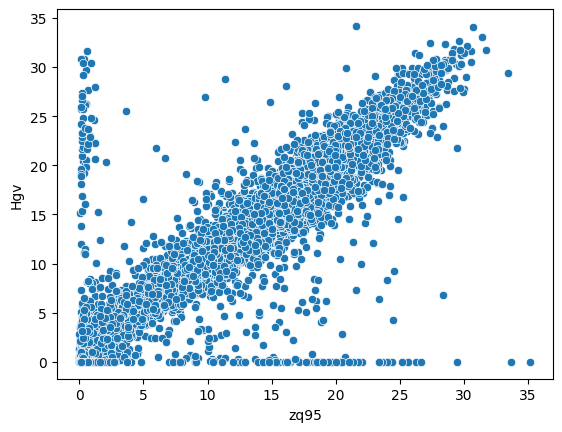

In [13]:
#merge field data and lidr metrics
merged_data = pd.merge(left = field_data, right = lidr_data, left_on = 'Description', right_on = 'Plot', how = 'inner')
sns.scatterplot(x = 'zq95', y = 'Hgv', data = merged_data)

<Axes: xlabel='east_processed', ylabel='north_processed'>

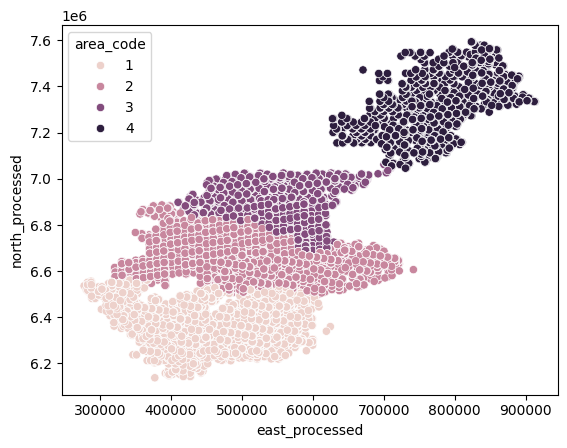

In [14]:
#check if coordinates are in a given area
def get_north(row):
    elem = row['north']
    if type(elem) == int:
        elem = elem
    else:
        elem = elem.replace(',', '.')
        elem = float(elem)
        elem = int(elem)
    return elem

def get_east(row):
    elem = row['east']
    if type(elem) == int:
        elem = elem
    else:
        elem = elem.replace(',', '.')
        elem = float(elem)
        elem = int(elem)
    return elem
        
merged_data['north_processed'] = merged_data.apply(get_north, axis=1)
merged_data['east_processed'] = merged_data.apply(get_east, axis=1)

def in_area(row):
    point = Point(row['east_processed'], row['north_processed'])
    if shapefile_gotaland.contains(point).any():
        return 1
    elif shapefile_svealand.contains(point).any():
        return 2
    elif shapefile_sodra_norrland.contains(point).any():
        return 3
    elif shapefile_norra_norrland.contains(point).any():
        return 4


merged_data['area_code'] = merged_data.apply(in_area, axis = 1)

#make sure it is correct
sns.scatterplot(merged_data, x='east_processed', y='north_processed', hue = 'area_code')

In [ ]:
#read raster data based on nfi plot names, and store corresponding nfi target data (to have same dataset for all methods)
raster_data_path = r'.\Image_data\tif_surrounding_processed'
raster_images_paths = []
for index, row in merged_data.iterrows():
    path = os.path.join(raster_data_path, str(row['Description']) + '.tif').replace('\\', '/')
    merged_data.loc[index, 'raster_image_path'] = path
merged_data.dropna(subset=['raster_image_path'], inplace=True)
merged_data

,Description,radius,datum,east,north,ForestClass,Biomassa_above,Biomassa_below,Basal_area,Basal_Area_Pine,...,n,area,l_1,l_2,t_3,t_4,north_processed,east_processed,area_code,raster_image_path
0,201815141060,10,2018-09-25,634600,7155900,42,35.093440,13.255406,8.756197,0.000,...,967,382.9224,4.596298,2.499172,0.215161,-0.011000,7155900,634600,4,./Image_data/tif_surrounding_processed/2018151...
1,201815141120,10,2018-09-25,635200,7155900,41,116.065283,41.412721,28.917372,0.000,...,956,389.4592,4.968347,2.532551,0.176622,-0.002693,7155900,635200,4,./Image_data/tif_surrounding_processed/2018151...
2,201815142060,10,2018-09-25,635200,7155300,31,40.464215,14.967116,13.113387,0.000,...,1138,385.1316,4.187768,1.741476,0.050151,0.036234,7155300,635200,4,./Image_data/tif_surrounding_processed/2018151...
3,201815142120,10,2018-09-25,635200,7154700,31,47.618797,17.225542,14.319336,0.000,...,840,390.4575,2.186786,1.218010,0.250577,0.010512,7154700,635200,4,./Image_data/tif_surrounding_processed/2018151...
4,201815143120,10,2018-09-25,634100,7154700,31,71.220743,26.837801,21.769043,0.000,...,1160,392.4325,4.333000,1.881727,0.025315,-0.038537,7154700,634100,4,./Image_data/tif_surrounding_processed/2018151...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10079,202258072030,10,2022-09-22,298400,6511700,23,0.000000,0.000000,0.000000,0.000,...,542,385.1134,0.427048,0.321168,0.578249,0.288894,6511700,298400,1,./Image_data/tif_surrounding_processed/2022580...
10080,202258074030,10,2022-09-22,298100,6511900,42,131.690016,46.993847,29.247315,0.000,...,951,394.4147,7.910557,3.391360,0.053666,0.018980,6511900,298100,1,./Image_data/tif_surrounding_processed/2022580...
10081,202258091030,10,2022-08-24,303200,6522000,42,95.225084,31.772678,22.800692,16.716,...,756,384.3554,5.827354,3.499902,0.243929,-0.097219,6522000,303200,1,./Image_data/tif_surrounding_processed/2022580...
10082,202258093030,10,2022-08-24,303000,6521700,42,177.189243,60.657853,43.352197,19.164,...,792,349.4502,8.880707,3.985172,-0.016583,-0.121046,6521700,303000,1,./Image_data/tif_surrounding_processed/2022580...


coef: 0.9185332921885949, intercept: 1.684510017552041


Text(0.5, 1.0, 'percentage of data removed: 3.599761999206664 %')

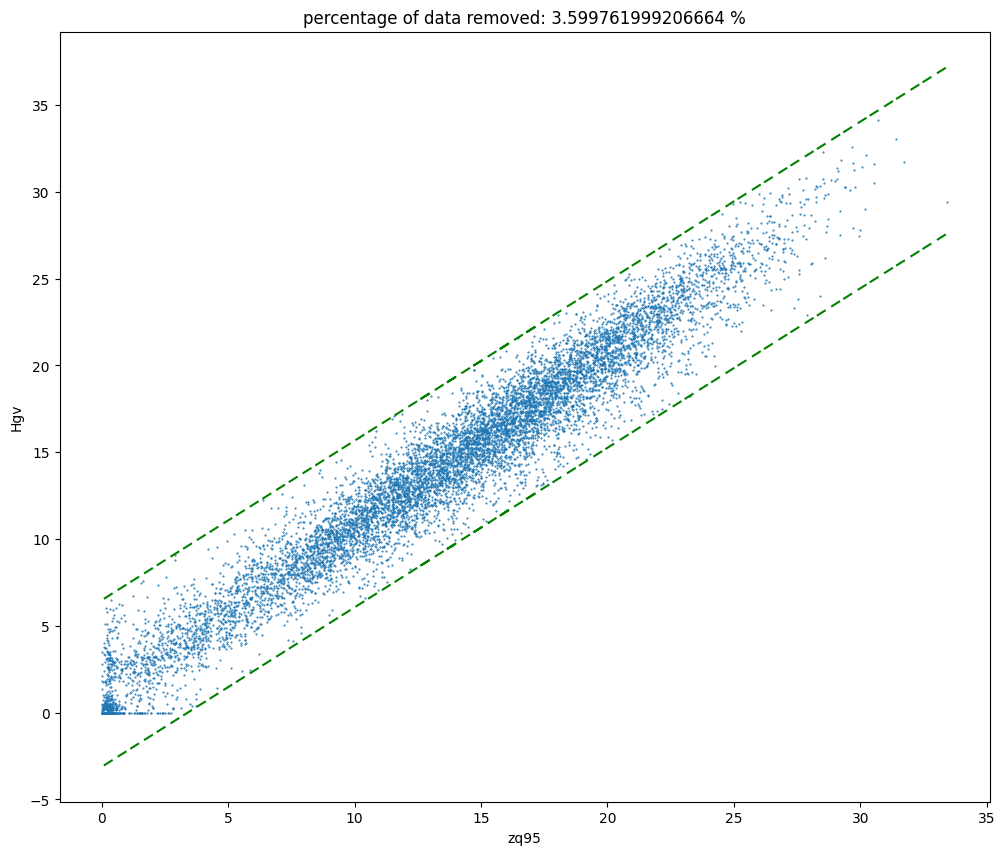

In [16]:
#build a linear regression model on h_p95 vs ground truth height
#use linear regression to remove anomalies
#adjust the threshold to match harvested stem volume (in Latvia ~ 3%, in Sweden ~ 3.6%)
margin_pos = 4.8 #adjust this if needed
margin_neg = -4.8
merged_data_cleaned = merged_data
z95s = np.array(merged_data['zq95']).reshape(-1, 1)
heights = merged_data['Hgv']
reg = LinearRegression().fit(z95s, heights)
a = reg.coef_[0]
b = reg.intercept_
print(f'coef: {a}, intercept: {b}')

indices_to_keep = []
for index, row in merged_data_cleaned.iterrows():
    height = row['Hgv']
    zq95 = row['zq95']
    pred_height = a* zq95 + b
    if margin_neg < height - pred_height < margin_pos:
        indices_to_keep.append(index)

merged_data_cleaned = merged_data_cleaned.loc[indices_to_keep]          
plt.figure(figsize = (12,10))
plt.plot(merged_data_cleaned['zq95'], merged_data_cleaned['Hgv'], '.', markersize = 1)
plt.plot(merged_data_cleaned['zq95'], a* merged_data_cleaned['zq95'] + b + margin_pos, '--', color = 'g', dashes = (5,10))
plt.plot(merged_data_cleaned['zq95'], a* merged_data_cleaned['zq95'] + b + margin_neg, '--', color = 'g', dashes = (5,10))
plt.xlabel('zq95')
plt.ylabel('Hgv')
#check ow much data is removed
plt.title(f'percentage of data removed: {((len(merged_data) - len(merged_data_cleaned)) / len(merged_data)) * 100} %')

In [17]:
#print the final dataset
merged_data_cleaned

,Description,radius,datum,east,north,ForestClass,Biomassa_above,Biomassa_below,Basal_area,Basal_Area_Pine,...,n,area,l_1,l_2,t_3,t_4,north_processed,east_processed,area_code,raster_image_path
0,201815141060,10,2018-09-25,634600,7155900,42,35.093440,13.255406,8.756197,0.000,...,967,382.9224,4.596298,2.499172,0.215161,-0.011000,7155900,634600,4,./Image_data/tif_surrounding_processed/2018151...
1,201815141120,10,2018-09-25,635200,7155900,41,116.065283,41.412721,28.917372,0.000,...,956,389.4592,4.968347,2.532551,0.176622,-0.002693,7155900,635200,4,./Image_data/tif_surrounding_processed/2018151...
2,201815142060,10,2018-09-25,635200,7155300,31,40.464215,14.967116,13.113387,0.000,...,1138,385.1316,4.187768,1.741476,0.050151,0.036234,7155300,635200,4,./Image_data/tif_surrounding_processed/2018151...
3,201815142120,10,2018-09-25,635200,7154700,31,47.618797,17.225542,14.319336,0.000,...,840,390.4575,2.186786,1.218010,0.250577,0.010512,7154700,635200,4,./Image_data/tif_surrounding_processed/2018151...
4,201815143120,10,2018-09-25,634100,7154700,31,71.220743,26.837801,21.769043,0.000,...,1160,392.4325,4.333000,1.881727,0.025315,-0.038537,7154700,634100,4,./Image_data/tif_surrounding_processed/2018151...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10079,202258072030,10,2022-09-22,298400,6511700,23,0.000000,0.000000,0.000000,0.000,...,542,385.1134,0.427048,0.321168,0.578249,0.288894,6511700,298400,1,./Image_data/tif_surrounding_processed/2022580...
10080,202258074030,10,2022-09-22,298100,6511900,42,131.690016,46.993847,29.247315,0.000,...,951,394.4147,7.910557,3.391360,0.053666,0.018980,6511900,298100,1,./Image_data/tif_surrounding_processed/2022580...
10081,202258091030,10,2022-08-24,303200,6522000,42,95.225084,31.772678,22.800692,16.716,...,756,384.3554,5.827354,3.499902,0.243929,-0.097219,6522000,303200,1,./Image_data/tif_surrounding_processed/2022580...
10082,202258093030,10,2022-08-24,303000,6521700,42,177.189243,60.657853,43.352197,19.164,...,792,349.4502,8.880707,3.985172,-0.016583,-0.121046,6521700,303000,1,./Image_data/tif_surrounding_processed/2022580...


In [18]:
#save to new csv file
merged_data_cleaned.to_csv('Image_data/merged_data_cleaned.csv')